# Loan Data Analysis
Yingcan Carol Wang

## Data Background
For this project, I used a dataset from Lending Club - a US online P2P lending company. Through Lending Club, investors provide funds for borrowers and earn a profit based on the risk they take (depending on the borrowers' credit score). Lending Club makes money by collecting fees from both borrowers and investors. This dataset mostly includes information from the borrower's side, ranging from the year 2007 to 2015.  

## Project Goals
1. Cluster borrowers into different types so as to facilitate targetted marketing and risk management.
<br><br>
2. Forcast and predict overall loan amount to help estimate market demand and run campaigns targeting at borrowers or investors at the right time.
<br><br>
3. Predict bad loan so as to reduce risk for the platform and its investors.


## General Data Cleaning

In [45]:
# Import libraries 
import pandas as pd
import numpy as np
#import tensorflow as tf

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

# classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# others
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
import collections
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import time
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
df = pd.read_csv('loan.csv', low_memory=False)
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-1985,1.0,NaN,NaN,3.0,0.0,13648.0,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,Jan-2015,171.62,NaN,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-1999,5.0,NaN,NaN,3.0,0.0,1687.0,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-2013,119.66,NaN,Sep-2013,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,small_business,real estate business,606xx,IL,8.72,0.0,Nov-2001,2.0,NaN,NaN,2.0,0.0,2956.0,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,Jun-2014,649.91,NaN,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0.0,Feb-1996,1.0,35.0,NaN,10.0,0.0,5598.0,21.0,37.0,f,0.0,0.0,12226.302212,12226.30,10000.00,2209.33,16.97,0.00,0.00,Jan-2015,357.48,NaN,Jan-2015,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-2011,Current,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > I plan on combi...,other,Personal,972xx,OR,17.94,0.0,Jan-1996,0.0,38.0,NaN,15.0,0.0,27783.0,53.9,38.0,f,766.9,766.9,3242.170000,3242.17,2233.10,1009.07,0.00,0.00,0.00,Jan-2016,67.79,Feb-2016,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df.shape

(887379, 74)

The dataset contains 74 columns, but not all of them would be useful for this project. I pick the following features that are most relevant to the three goals of the project:
* loan_amnt
* funded_amnt_inv (the total amount committed by investors for that loan at that point in time)
* term (the number of payments on the loan, either in 36 or 60 months)
* int_rate (interest rate)
* installment
* grade (loan grade based on credit score)
* emp_length (employment time)
* home_ownership
* annual_inc (annual income)
* verification_status (whether income is verified)
* issue_d (the month which the loan was funded)
* loan_status 
* purpose (borrowing purpose)
* addr_state (the US state provided by the borrower as the address)
* dti (debt-income ratio)
* delinq_2yrs (the number of delinquency in the past 2 years)
* inq_last_6mths (the number of inquiries in the past 6 months) 
* total_acc (the total number of current credit lines)
* out_prncp (remaining outstanding principal for total amount funded)
* pub_rec (the number of derogatory public records)
* revol_bal (total credit revolving balance)
* revol_util (the amount of credit the borrower is using relative to all available revolving credit)

In [4]:
df_selected = df[['loan_amnt','funded_amnt_inv','term','int_rate','installment','grade',
                  'emp_length','home_ownership','annual_inc','verification_status','issue_d',
                  'loan_status','purpose',
                  'addr_state','dti','delinq_2yrs','inq_last_6mths',
                  'total_acc',
                  'out_prncp','pub_rec','revol_bal','revol_util']]

In [5]:
# check missing data
df_selected.isnull().sum()

loan_amnt                  0
funded_amnt_inv            0
term                       0
int_rate                   0
installment                0
grade                      0
emp_length             44825
home_ownership             0
annual_inc                 4
verification_status        0
issue_d                    0
loan_status                0
purpose                    0
addr_state                 0
dti                        0
delinq_2yrs               29
inq_last_6mths            29
total_acc                 29
out_prncp                  0
pub_rec                   29
revol_bal                  0
revol_util               502
dtype: int64

Since the row number of missing data only takes up ~5% of all rows and there is enough amount of data (887379 rows), deleting them will not affect our statistical power. 

In [6]:
# delete missing data
df_cleaned = df_selected.dropna()
df_cleaned.shape

(842067, 22)

In [7]:
df_cleaned.head(3)

,loan_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,addr_state,dti,delinq_2yrs,inq_last_6mths,total_acc,out_prncp,pub_rec,revol_bal,revol_util
0,5000.0,4975.0,36 months,10.65,162.87,B,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,credit_card,AZ,27.65,0.0,1.0,9.0,0.0,0.0,13648.0,83.7
1,2500.0,2500.0,60 months,15.27,59.83,C,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,car,GA,1.00,0.0,5.0,4.0,0.0,0.0,1687.0,9.4
2,2400.0,2400.0,36 months,15.96,84.33,C,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,small_business,IL,8.72,0.0,2.0,10.0,0.0,0.0,2956.0,98.5


In [8]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 842067 entries, 0 to 887378
Data columns (total 22 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   loan_amnt            842067 non-null  float64
 1   funded_amnt_inv      842067 non-null  float64
 2   term                 842067 non-null  object 
 3   int_rate             842067 non-null  float64
 4   installment          842067 non-null  float64
 5   grade                842067 non-null  object 
 6   emp_length           842067 non-null  object 
 7   home_ownership       842067 non-null  object 
 8   annual_inc           842067 non-null  float64
 9   verification_status  842067 non-null  object 
 10  issue_d              842067 non-null  object 
 11  loan_status          842067 non-null  object 
 12  purpose              842067 non-null  object 
 13  addr_state           842067 non-null  object 
 14  dti                  842067 non-null  float64
 15  delinq_2yrs      

In [9]:
df_cleaned.describe()

,loan_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,total_acc,out_prncp,pub_rec,revol_bal,revol_util
count,842067.000000,842067.000000,842067.000000,842067.000000,8.420670e+05,842067.000000,842067.000000,842067.000000,842067.000000,842067.000000,842067.000000,8.420670e+05,842067.000000
mean,14915.479321,14860.788718,13.244072,440.779140,7.634501e+04,18.061077,0.317167,0.696321,25.339776,8466.188997,0.189016,1.708633e+04,55.228812
std,8449.246664,8457.198501,4.385640,244.625379,6.563192e+04,8.277712,0.865776,1.000607,11.845235,8554.460606,0.576540,2.261416e+04,23.814760
min,500.000000,0.000000,5.320000,15.670000,1.896000e+03,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,8325.000000,8150.000000,9.990000,263.930000,4.700000e+04,11.880000,0.000000,0.000000,17.000000,0.000000,0.000000,6.533000e+03,37.900000
50%,13200.000000,13150.000000,12.990000,386.740000,6.500000e+04,17.580000,0.000000,0.000000,24.000000,6542.560000,0.000000,1.201100e+04,56.200000
75%,20000.000000,20000.000000,16.200000,577.500000,9.000000e+04,23.830000,0.000000,1.000000,32.000000,13805.760000,0.000000,2.102300e+04,73.700000
max,35000.000000,35000.000000,28.990000,1445.460000,9.500000e+06,380.530000,39.000000,33.000000,169.000000,49372.860000,86.000000,2.904836e+06,892.300000


Next, we need to correct some features' data types and combine some catogories in a few categorical fetures. 

In [10]:
df_cleaned['emp_length'].value_counts()

10+ years    291417
2 years       78831
< 1 year      70538
3 years       69991
1 year        57055
5 years       55677
4 years       52503
7 years       44566
8 years       43929
6 years       42926
9 years       34634
Name: emp_length, dtype: int64

In [11]:
#column 'emp_length' can be treated as continuous data, so convert it to integer
#'< 1 year' will be 0, '10+ years' will be 10
emp_length = df_cleaned['emp_length'].str.split(" ",expand=True)[0]
df_cleaned['employment_length'] = emp_length.replace(["10+","<"],[10,0]).astype(int)

In [12]:
# column issue_d should be converted to date type
df_cleaned['issue_date'] = pd.to_datetime(df_cleaned['issue_d'])

In [13]:
df_cleaned['loan_status'].value_counts()

Current                                                568447
Fully Paid                                             200203
Charged Off                                             42680
Late (31-120 days)                                      10863
Issued                                                   7826
In Grace Period                                          6013
Late (16-30 days)                                        2213
Does not meet the credit policy. Status:Fully Paid       1935
Default                                                  1147
Does not meet the credit policy. Status:Charged Off       740
Name: loan_status, dtype: int64

In [14]:
# All categories including Charged Off, Late, In Grace Period and Default 
# should be combine into a 'bad loan' category.
bad_loan_list = ['Charged Off','Late (31-120 days)','In Grace Period','Late (16-30 days)',
                 'Default','Does not meet the credit policy. Status:Charged Off']
# Good loan and onging loan, we combine them together here 
good_loan_list = ['Fully Paid','Current','Issued',
                  'Does not meet the credit policy. Status:Fully Paid']
df_cleaned['loan_status_combined'] = df_cleaned['loan_status'].replace(bad_loan_list,'bad_loan') 
df_cleaned['loan_status_combined'] = df_cleaned['loan_status_combined'].replace(good_loan_list,'good_loan') 
                                                            

In [15]:
df_cleaned.loan_status_combined.value_counts()

good_loan    778411
bad_loan      63656
Name: loan_status_combined, dtype: int64

In [16]:
#label encode loan status to 0 and 1
df_cleaned['loan_status_encoded'] = df_cleaned['loan_status_combined'].replace({'good_loan':0,
                                                                                'bad_loan':1})

In [17]:
#convert delinq_2yrs, inq_last_6mths, total_acc and pub_rec to integer
df_cleaned['delinq_2yrs'] = df_cleaned['delinq_2yrs'].astype(int)
df_cleaned['inq_last_6mths'] = df_cleaned['inq_last_6mths'].astype(int)
df_cleaned['total_acc'] = df_cleaned['total_acc'].astype(int)
df_cleaned['pub_rec'] = df_cleaned['pub_rec'].astype(int)

In [59]:
#label encode grade
df_cleaned['grade_encoded'] = df_cleaned['grade'].replace({'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,
                                                          'G':7})

## Borrower Clustering
In order to conduct targeted marketing and risk management, we need to understand the borrowers better. One way to do so is to cluster borrowers based on relevant features, so that it will be easier to target different types of borrowers. The most relevant 3 categories of features are the following:

* Loan demand
    * loan_amnt
    * total_acc
    * purpose
    * revol_util
* Loan repayment ability
    * emp_length
    * annual_inc
    * dti
    * revol_bal 
* Loan repayment willingness
    * grade 
    * delinq_2yrs 
    * inq_last_6mths 
    * pub_rec 

<br>With these 3 categories, we can cluster borrowers using 3 different combinations:
1. loan repayment ability and willingness
2. loan demand and loan repayment ability
3. loan demand and loan repayment willingness

<br>What we need to do next is to choose the most representative feature within each category. Within the loan demand category, 'loan_amnt' reflects the demand most directly. As for loan repayment ability and willingness, a heatmap reflecting the correlation between these features and loan status would be most helpful for feature selection.

<br>It is also important to convert the variables into integers and scale them before clustering with kmeans. 

In [60]:
df_cleaned.head(3)

,loan_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,addr_state,dti,delinq_2yrs,inq_last_6mths,total_acc,out_prncp,pub_rec,revol_bal,revol_util,employment_length,issue_date,loan_status_combined,loan_status_encoded,grade_encoded
0,5000.0,4975.0,36 months,10.65,162.87,B,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,credit_card,AZ,27.65,0,1,9,0.0,0,13648.0,83.7,10,2011-12-01,good_loan,0,2
1,2500.0,2500.0,60 months,15.27,59.83,C,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,car,GA,1.00,0,5,4,0.0,0,1687.0,9.4,0,2011-12-01,bad_loan,1,3
2,2400.0,2400.0,36 months,15.96,84.33,C,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,small_business,IL,8.72,0,2,10,0.0,0,2956.0,98.5,10,2011-12-01,good_loan,0,3


In [61]:
#subset dataframe based on repayment ability and willingness
df_ability = df_cleaned[['employment_length','annual_inc','dti','revol_bal','loan_status_encoded']]
df_willingness = df_cleaned[['grade_encoded','delinq_2yrs','inq_last_6mths','pub_rec','loan_status_encoded']]

<AxesSubplot:>

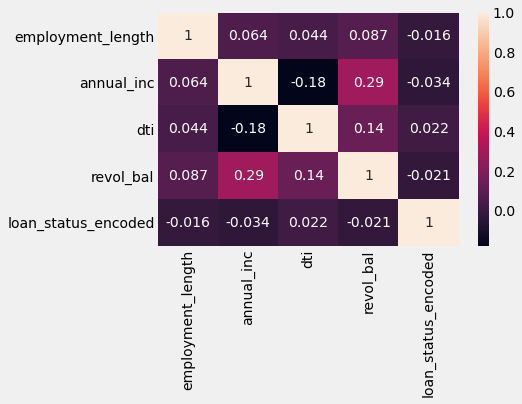

In [62]:
sns.heatmap(df_ability.corr(), annot=True)

It can be seen that the feature most closely related to loan status in the repayment ability category is the annual income (negative correlation, the higher the income, the less likely the loan will be bad). Hence I will use annual income to represent loan repayment ability.

<AxesSubplot:>

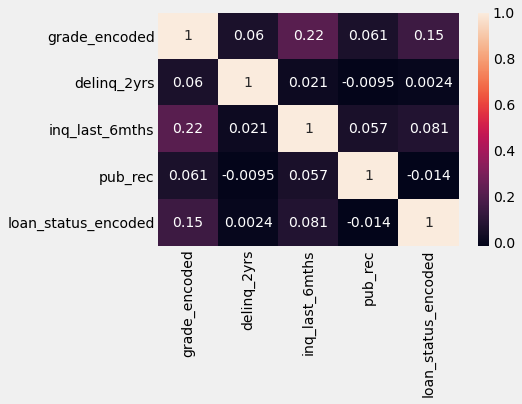

In [63]:
sns.heatmap(df_willingness.corr(), annot=True)

The feature most clostly related to loan status in the repayment willingness category is the credit grade (positive correlation, the higher the grade, the more likely the loan will be bad). Therefore, I will use grade to represent loan repayment willingness.

In [64]:
#data frame for features to be used for clustering
df_cluster = df_cleaned[['loan_amnt','annual_inc','grade_encoded']]

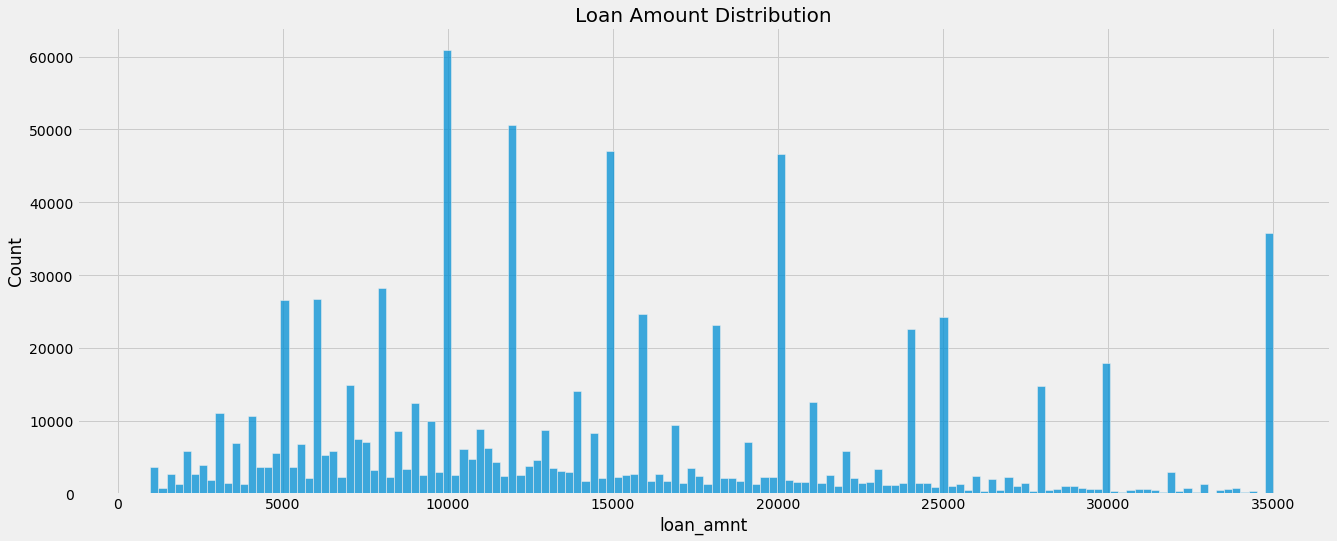

In [103]:
#plot loan_amnt
plt.rcParams['figure.figsize'] = (20, 8)
sns.histplot(df_cluster['loan_amnt'])
plt.title('Loan Amount Distribution', fontsize = 20)
plt.show()

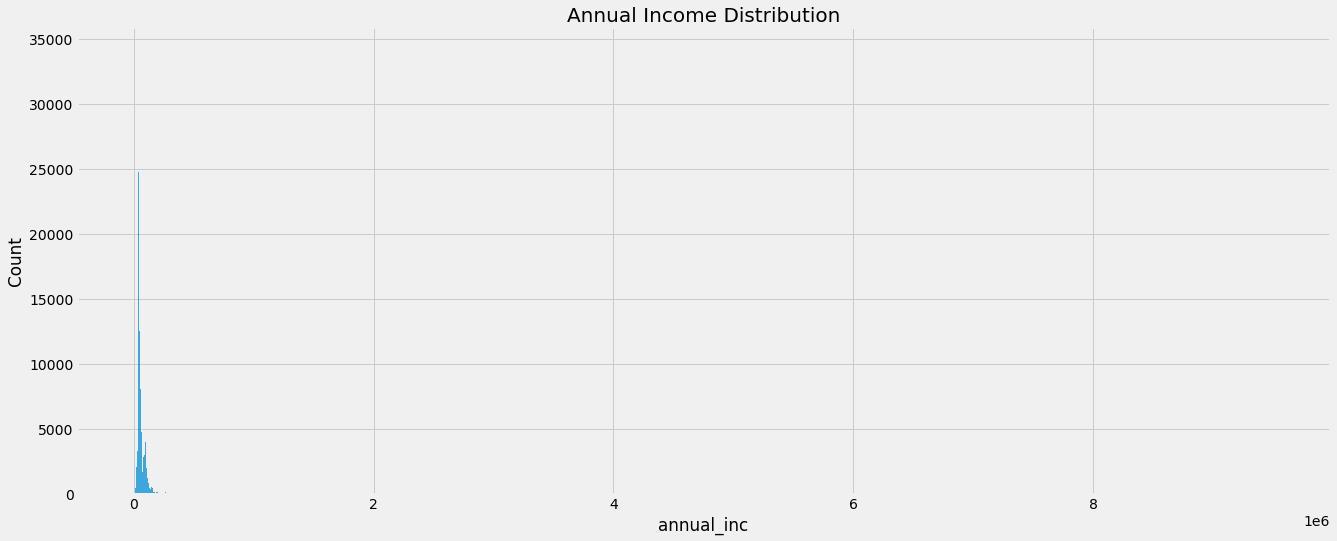

In [100]:
#plot annual income
plt.rcParams['figure.figsize'] = (20, 8)
sns.histplot(df_cluster['annual_inc'])
plt.title('Annual Income Distribution', fontsize = 20)
plt.show()

It looks like the annual income distribution is heavily skewed, we'll log transform the data here.

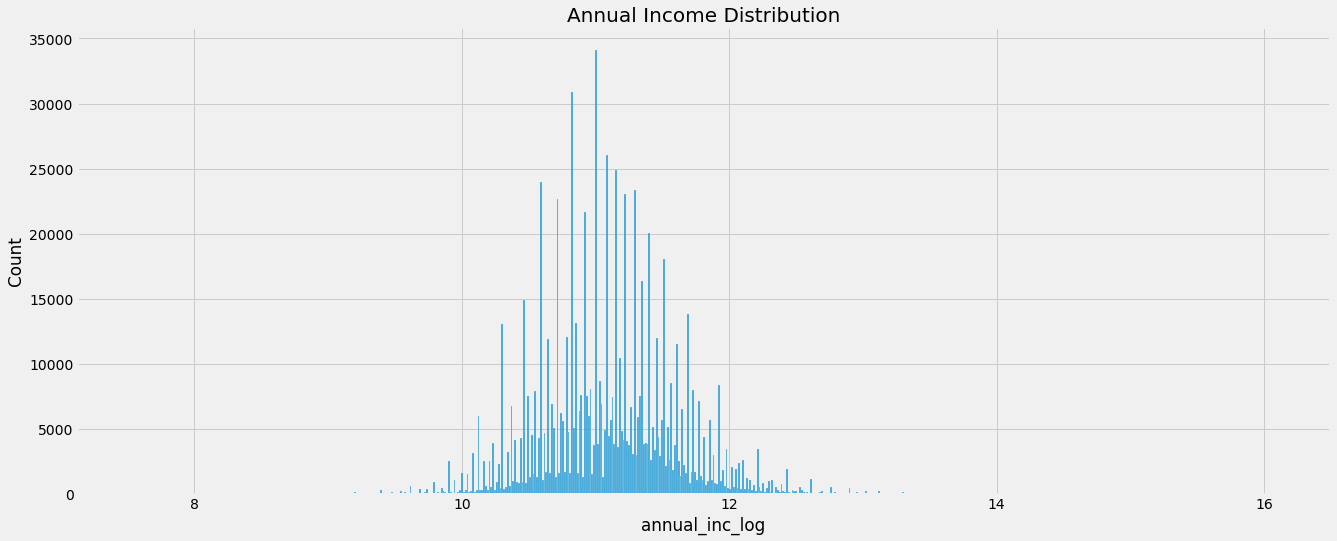

In [115]:
#log transformation of annual income
df_cluster['annual_inc_log'] = np.log1p(df_cluster['annual_inc'])
plt.rcParams['figure.figsize'] = (20, 8)
sns.histplot(df_cluster['annual_inc_log'])
plt.title('Annual Income Distribution', fontsize = 20)
plt.show()

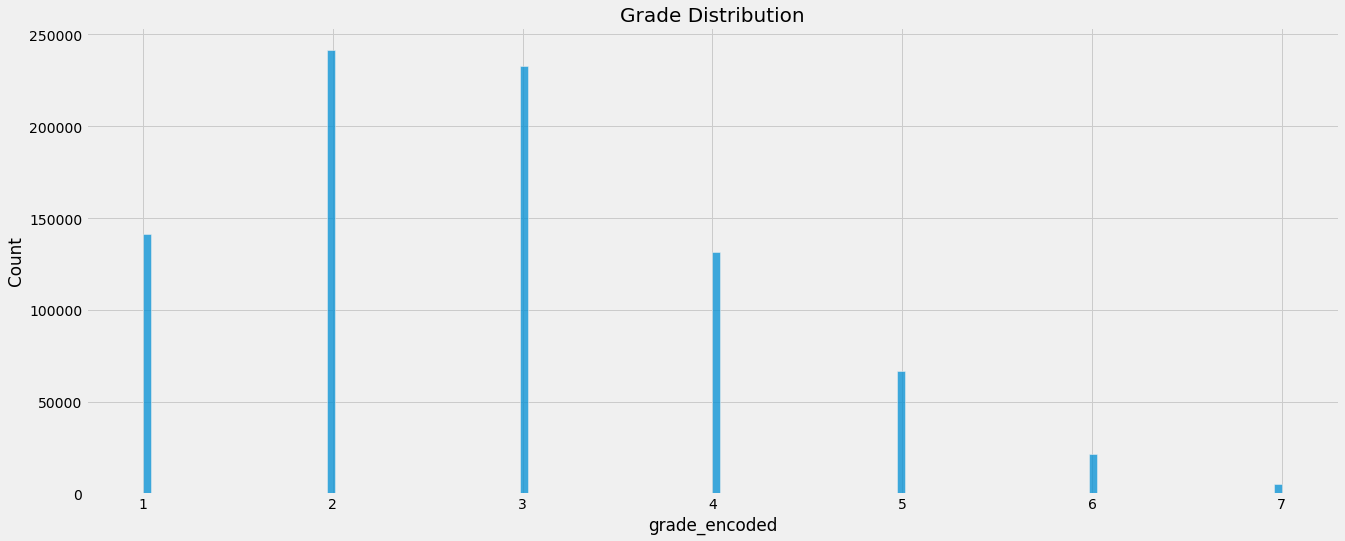

In [104]:
#plot grade
plt.rcParams['figure.figsize'] = (20, 8)
sns.histplot(df_cluster['grade_encoded'])
plt.title('Grade Distribution', fontsize = 20)
plt.show()

In [116]:
df_cluster.head()

,loan_amnt,annual_inc,grade_encoded,annual_inc_log
0,5000,24000,2,10.085851
1,2500,30000,3,10.308986
2,2400,12252,3,9.413526
3,10000,49200,3,10.803669
4,3000,80000,2,11.289794


To prepare the data for the distance-based algorithm K means, we also need to standardize the data.

In [117]:
# #convert features to integers
# df_cluster['loan_amnt_int'] = df_cluster['loan_amnt'].astype(int)
# df_cluster['annual_inc_int'] = df_cluster['annual_inc'].astype(int)
#standardize the data 
scaler = StandardScaler()
df_cluster_scaled = scaler.fit_transform(df_cluster)

In [118]:
pd.DataFrame(df_cluster_scaled).describe()

,0,1,2,3
count,8.420670e+05,8.420670e+05,8.420670e+05,8.420670e+05
mean,2.733937e-17,-1.424348e-17,-1.203945e-16,1.041819e-14
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.706127e+00,-1.134342e+00,-1.367264e+00,-6.867332e+00
25%,-7.800084e-01,-4.471151e-01,-6.063243e-01,-6.560832e-01
50%,-2.030335e-01,-1.728581e-01,1.546158e-01,-2.868062e-02
75%,6.017724e-01,2.080543e-01,9.155559e-01,6.010137e-01
max,2.377080e+00,1.435835e+02,3.198376e+00,9.616764e+00


In [121]:
pd.DataFrame(df_cluster_scaled).head()

,0,1,2,3
0,-1.173535,-0.797555,-0.606324,-1.956566
1,-1.469419,-0.706136,0.154616,-1.524793
2,-1.481255,-0.976553,0.154616,-3.257536
3,-0.581766,-0.413595,0.154616,-0.567565
4,-1.410242,0.055689,-0.606324,0.373103


#### Loan repayment ability x willingness
We will cluster borrowers based on their annual income (repayment ability) and grade (repayment willingness) first.

In [119]:
data1 = df_cluster_scaled[:,[3,2]]

In [120]:
data1

array([[-1.95656646, -0.60632434],
       [-1.52479276,  0.15461579],
       [-3.25753599,  0.15461579],
       ...,
       [-1.22651554,  0.91555592],
       [-0.04662512,  1.67649605],
       [ 0.80488752, -0.60632434]])

In order to find the optimal number of clusters (k), we will calculate the winthin-cluster-sum-of-squares (wcss) and choose the number k using the elbow point graph.


In [122]:
#calculate wcss for each number of k
wcss = []
for k in range(1, 11):
    km = KMeans(n_clusters = k, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    km.fit(data1)
    wcss.append(km.inertia_)

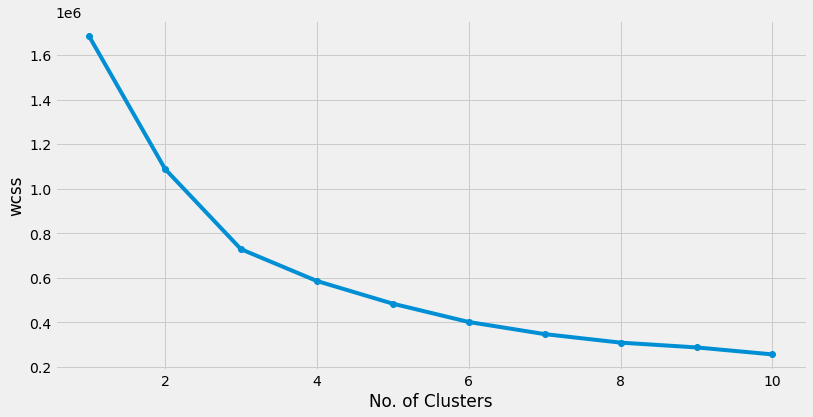

In [123]:
#The elbow point graph
plt.figure(figsize=(12,6))
plt.plot(range(1, 11), wcss, marker = 'o')
plt.xlabel('No. of Clusters')
plt.ylabel('wcss')
plt.show()

It seems that the optimal number of clusters is 4 (which is close to the 'elbow' point). 
Next, we will visualize the clusters.

In [131]:
#k = 4
km = KMeans(n_clusters = 4, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
y_means = km.fit_predict(data1)

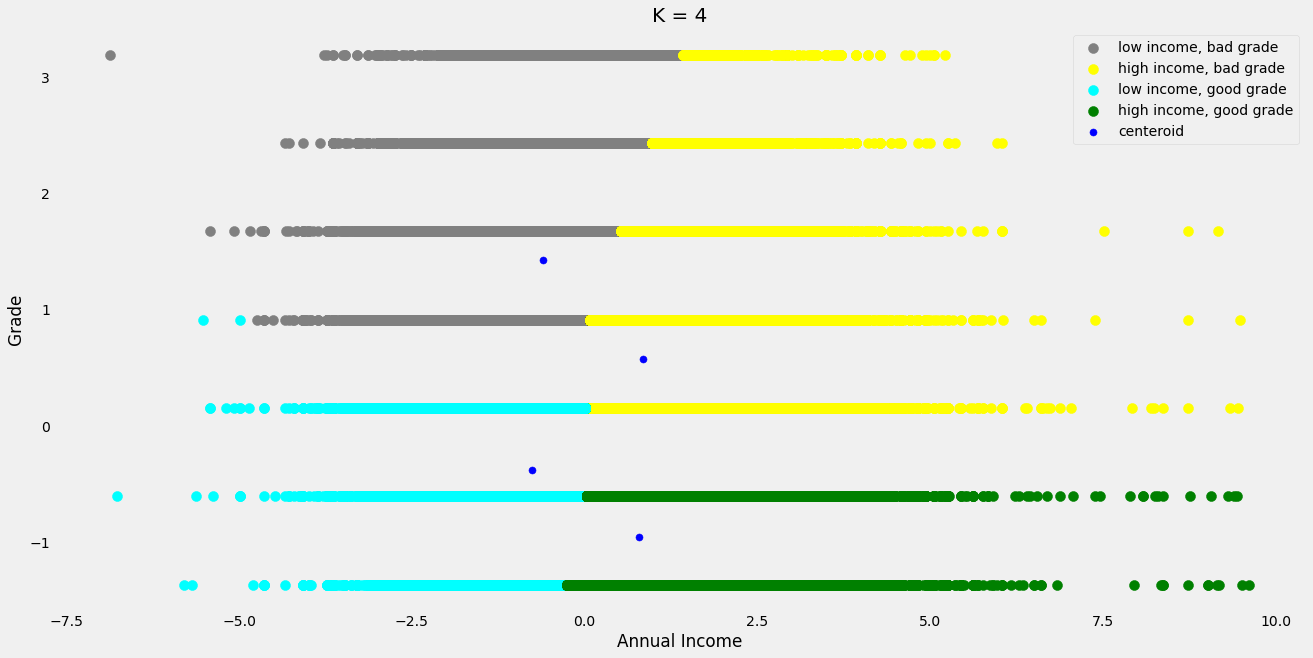

In [134]:
plt.figure(figsize=(20,10))
plt.scatter(data1[y_means == 0, 0], data1[y_means == 0, 1], s = 100, c = 'grey', label = 'low income, bad grade')
plt.scatter(data1[y_means == 1, 0], data1[y_means == 1, 1], s = 100, c = 'yellow', label = 'high income, bad grade')
plt.scatter(data1[y_means == 2, 0], data1[y_means == 2, 1], s = 100, c = 'cyan', label = 'low income, good grade')
plt.scatter(data1[y_means == 3, 0], data1[y_means == 3, 1], s = 100, c = 'green', label = 'high income, good grade')
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:, 1], s = 50, c = 'blue' , label = 'centeroid')

plt.title('K = 4', fontsize = 20)
plt.xlabel('Annual Income')
plt.ylabel('Grade')
plt.legend()
plt.grid()
plt.show()

Although grade is an ordinal variable, which is not optimal for kmeans algorithm, this clustering analysis still shows clear insights that borrowers can be segmented into 4 different types based on their annual income (loan repayment ability) and grade (loan repayment willingness). 
<br><br>
Those with high income and good grade are the ideal borrowers who should be retained by the Lending Club, bonus or vouchers can be given to these clients so that they are more willing to keep using the platform; those with low income and bad grade are risky borrowers that the platform may want to avoid or at least pay close attention to in order to reduce any potential risk; those with high income and bad grade are the borrowers that need to be reminded from time to time to repay their loan, they have the ability to repay the loan but they may forget to do so; while those with low income and good grade are borrowers who have good credibility but may not be able to repay their loan on time if the loan amount is way too large, so it may be helpful to set a loan amount limit on these borrowers based on their income. 
<br><br>
These are helpful insights that can help enhance lending club's borrower retention rate while keeping the overall risk low. 

#### Loan demand x repayment ability
Next, we will do a clustering analysis based on borrowers demand (loan amount) and repayment ability (annual income).

In [135]:
data2 = df_cluster_scaled[:,[3,0]]

In [142]:
#calculate wcss for each number of k
wcss2 = []
for k in range(1, 11):
    km = KMeans(n_clusters = k, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 1)
    km.fit(data2)
    wcss2.append(km.inertia_)

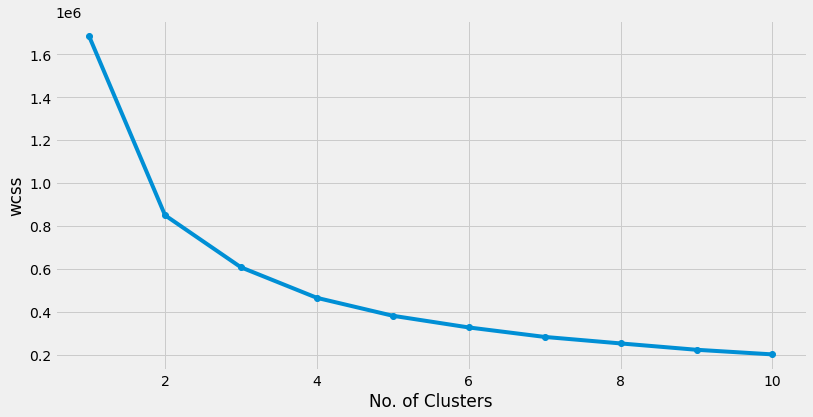

In [143]:
#The elbow point graph
plt.figure(figsize=(12,6))
plt.plot(range(1, 11), wcss2, marker = 'o')
plt.xlabel('No. of Clusters')
plt.ylabel('wcss')
plt.show()

Again, it looks like 4 is the optimal number of clusters.

In [144]:
#k = 4
km = KMeans(n_clusters = 4, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 1)
y_means = km.fit_predict(data2)

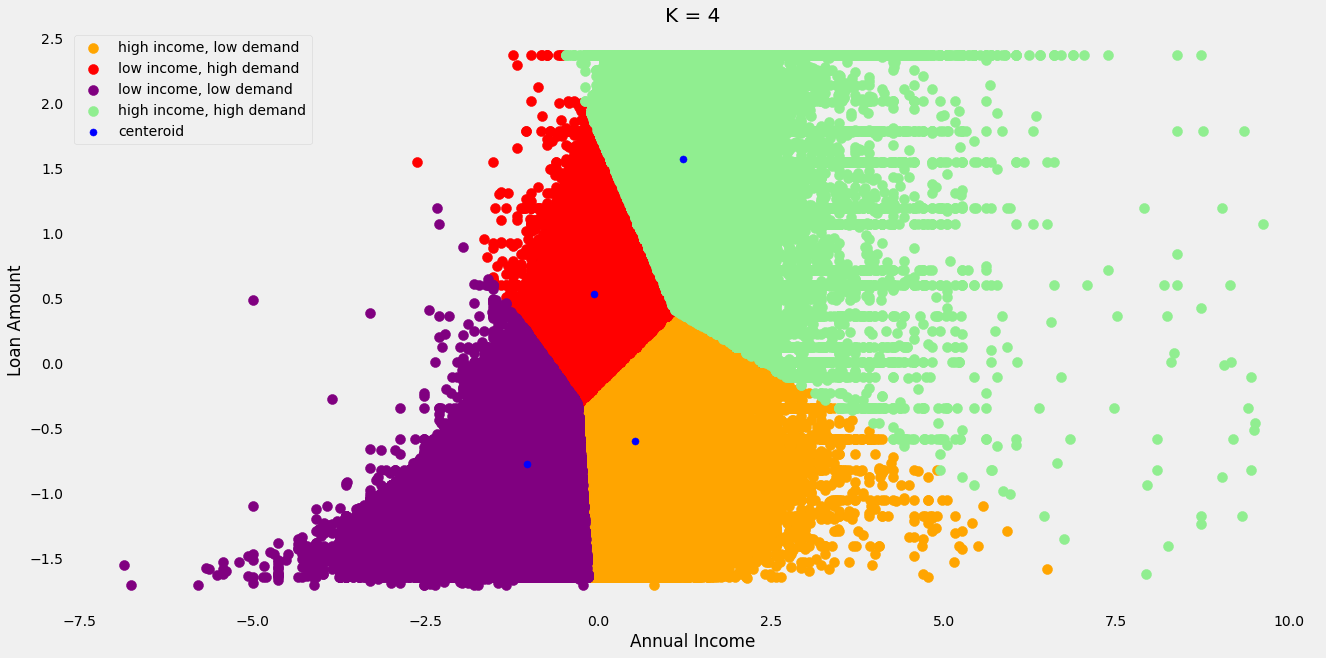

In [147]:
plt.figure(figsize=(20,10))
plt.scatter(data2[y_means == 0, 0], data2[y_means == 0, 1], s = 100, c = 'orange', label = 'high income, low demand')
plt.scatter(data2[y_means == 1, 0], data2[y_means == 1, 1], s = 100, c = 'red', label = 'low income, high demand')
plt.scatter(data2[y_means == 2, 0], data2[y_means == 2, 1], s = 100, c = 'purple', label = 'low income, low demand')
plt.scatter(data2[y_means == 3, 0], data2[y_means == 3, 1], s = 100, c = 'lightgreen', label = 'high income, high demand')
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:, 1], s = 50, c = 'blue' , label = 'centeroid')

plt.title('K = 4', fontsize = 20)
plt.xlabel('Annual Income')
plt.ylabel('Loan Amount')
plt.legend()
plt.grid()
plt.show()

We can learn from this analysis that borrowers with high income and high demand are priority clients that contribute the most to Lending Club. Borrowers with high income and low demand are targeted clients, the platform can use measures such as bonus to stimulate them more. Borrowers with low income and high demand are risky clients whom should be kept an eye on, the platform can probably set a loan amount limit on these clients. Borrowers with low income and low demand are relatively less important to the platform.

#### Loan demand x repayment ability x repayment willingness